---
tags:
- PyPJ
- 爬虫
- DA
---

# 哔哩哔哩番剧分析

## 内容摘要

> bilibili，全称为哔哩哔哩弹幕网，亦称哔哩哔哩、bilibili弹幕网，或简称为B站，是总部位于中国大陆上海的一个以ACG相关内容起家的弹幕视频分享网站。\
作为数据分析课程的期末论文，本项目从0开始收集B站的番剧数据，包括`播放量`、`追番人数`、`弹幕总数`、`评分`、`评分人数`等等一系列变量。\
而后进行数据的分析与可视化，数据分析部分主要是建立一元线性回归模型寻找播放量与其他变量之间的关系，可视化部分主要是对番剧类型(tag)进行研究。

**这里的番剧不仅仅包含动画内容、也包含电影、剧集等，只要包含在B站media之中的内容都进行统计分析**

In [1]:
# 此命令的参数仅在windows有效，unix下可以直接!tree
!tree ./ /f

卷 SA 的文件夹 PATH 列表
卷序列号为 000000FB 188E:35ED
C:\USERS\OMYGOOOOSH\ICLOUDDRIVE\GIT\JUPYTER-SERVER\数据分析期末
│  B站番剧分析.ipynb
│  
├─data
│      BLBLdata.xlsx
│      md7.html
│      mdidlist.txt
│      
└─figure
        corr.jpg
        CountOfBangumi.jpg
        fitted_OLS_model.jpg
        sorted_tagsDistrubution.jpg
        tagsByYear.jpg
        tagsDistrubution.jpg
        top10tags.jpg
        top10tags_cut.jpg
        


- 论文主体：`B站番剧分析.ipynb`，包含论述与相关代码、图表，而以下的全部数据、图表都是由代码生成
- 数据：
  - 爬虫获取的B站番剧信息：`BLBLdata.xlsx`，共16个变量一万四千条数据
  - md7(动画`漫研社`)的html代码：`md7.html`
  - 合法的mdid列表：`mdidlist.txt`，共计14685个合法的mdid
- 图表：
  - 相关系数图：`corr.jpg`
  - 番剧数量随着年份变化：`CountOfBangumi.jpg`
  - 回归拟合图：`fitted_OLS_model.jpg`
  - 按数量排序的tag分布：`sorted_tagsDistrubution.jpg`
  - 按年份分布的tag：`tagsByYear.jpg`
  - 未排序的tag分布：`tagsDistrubution.jpg`
  - 前十热门的tag：`top10tags.jpg`
  - 前十热门的tag裁切：`top10tags_cut.jpg`

## 依赖库

- `numpy`：statsmodel的依赖库
- `pandas`：处理数据
- `requests`：访问网站
- `matplotlib`：作图
- `seaborn`：作图
- `parsel`：分析网站
- `statsmodels`：回归分析
- `patsy`：在python中提供R语言语法支持的统计模型

## 数据抓取

In [2]:
# 内置
import re
import time
from datetime import datetime

# 第三方
import pandas as pd
import requests
import parsel

### 页面分析

我们抓取的是一个静态网页，以[md7](https://www.bilibili.com/bangumi/media/md7)为例：

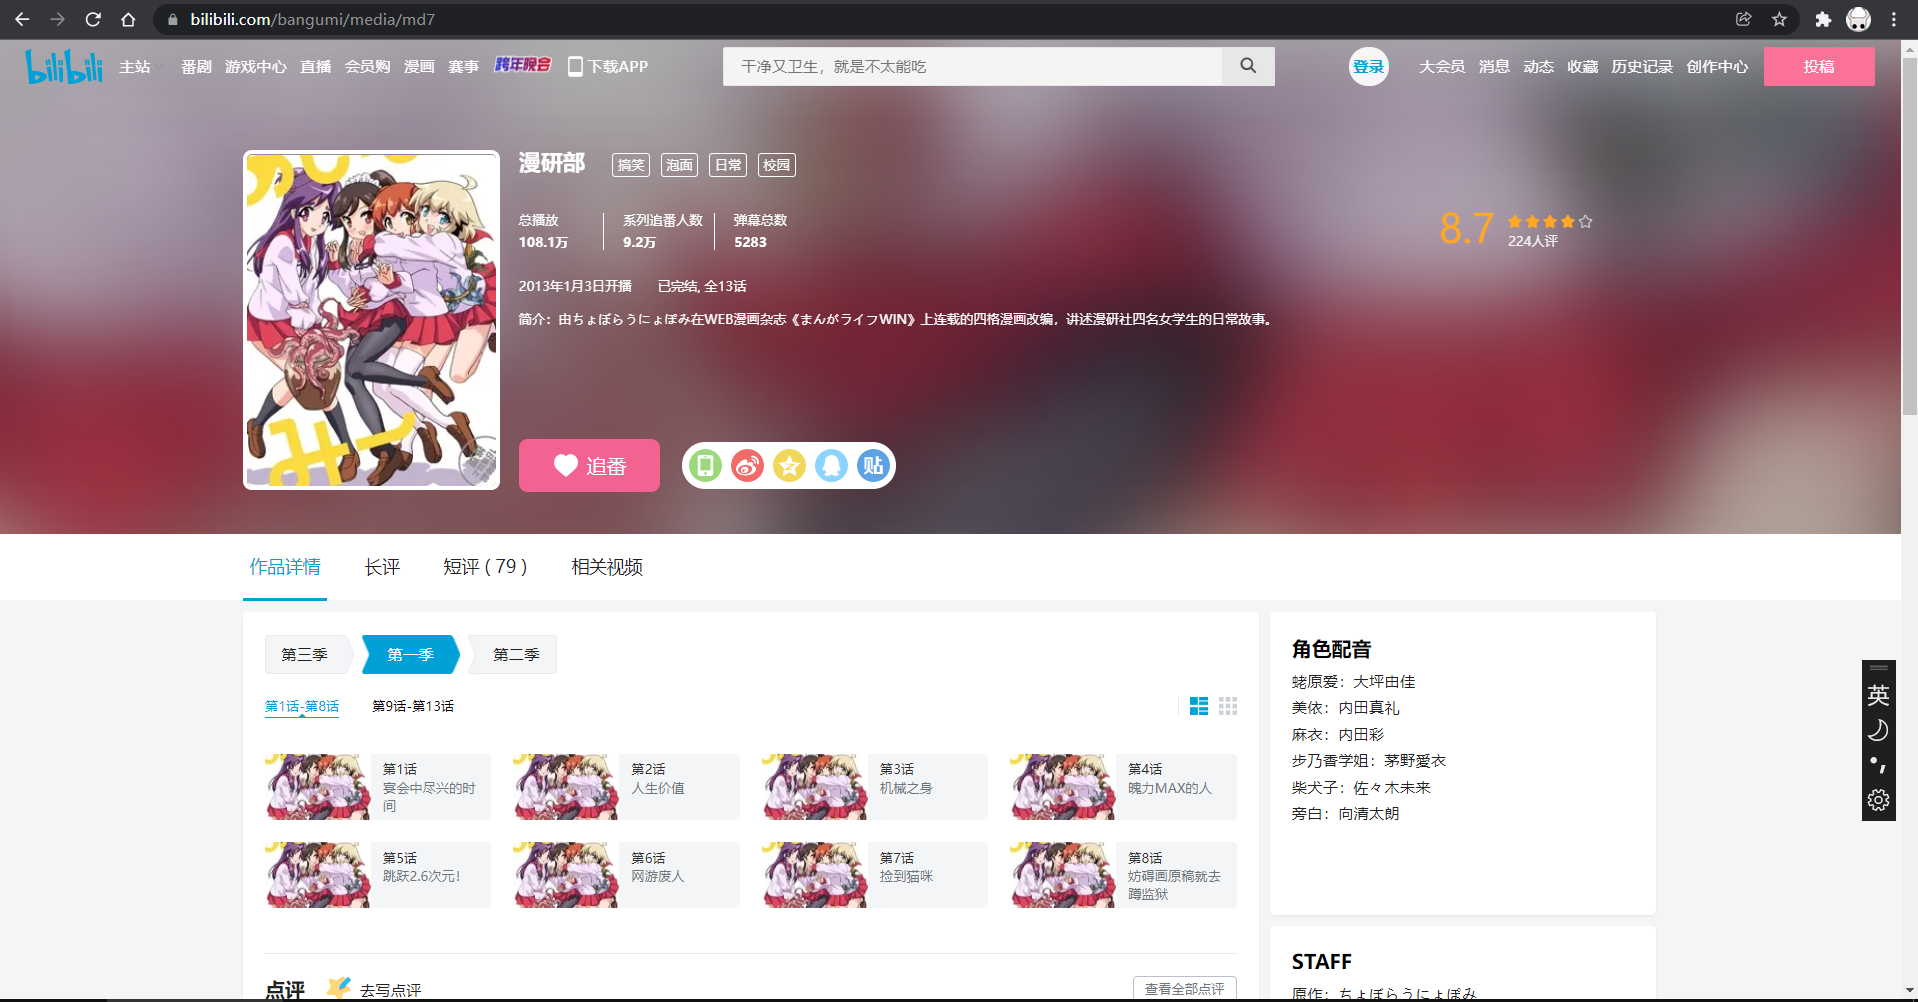

获取到网页的源代码后，找到如下有效信息：

1. 标题
    - 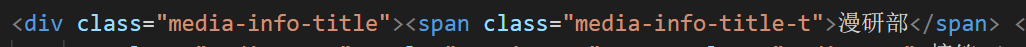
2. 番剧tag
    - 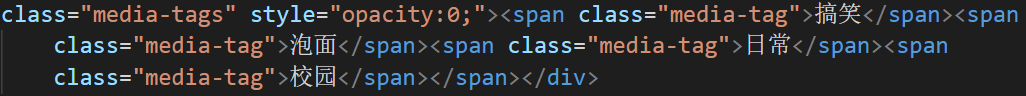
3. 番剧播放信息
    - 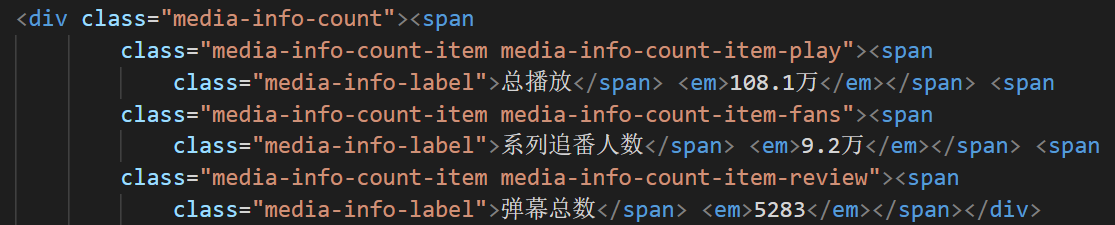
4. 评分情况
    - 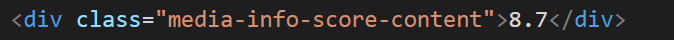
    - 
5. 开播信息
    - 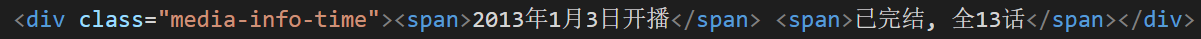

在大会员独播的番剧还会有如下相关字样:

- 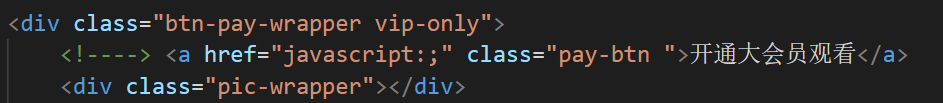

至此，以及找到了足够的信息，开始爬取

### 下载网页

已知番剧的media id时，使用requests库下载网页（本项目涉及的全是网页的静态内容），注意编码格式为utf-8

In [3]:
def gethtml(mdid):
    '''
    获取哔哩哔哩番剧详情页面的html文本
    input  mdid【int】
    output 对应番剧的详情页面【str】
    '''

    url = f'https://www.bilibili.com/bangumi/media/md{mdid}'
    response = requests.get(url)
    response.encoding = 'utf8'
    html = response.text
    # B站域名下非法的网址会跳转到错误页面，包含以下字符串
    if 'Σ(oﾟдﾟoﾉ) 无法找到该页面~' in html:
        html = 'invalid'
    return html

In [4]:
# 写入md7的html以便分析
with open('./data/md7.html','w',encoding='utf-8') as f:
    f.write(gethtml(7))

### 处理数字

B站的播放量、追番数以及弹幕数经常以万或者亿结尾，写一个函数转换一下

In [5]:
def eval_playdata(s):
    '''
    把playdata中的xxx万、亿转换为数字
    input  s【str】
    output 对应数字表达的整数值【int】
    '''

    d = {'万': 1e4, '亿': 1e8}
    try:
        #没有汉字，纯数字
        ans = eval(s)
    except SyntaxError:
        # 判断末尾是不是万或者亿，否则报错
        if s[-1] in d:
            ans = int(eval(s[:-1]) * d[s[-1]])
        else:
            ans = 'NA'
    return ans

### 处理日期

由于B站对开播时间的描述不尽相同，故而特别处理一下\
大致有一下几种情况：
- %Y年%m月%d日开播【例如[md7](https://www.bilibili.com/bangumi/media/md7)】
- %Y年%m月开播【例如[md9892](https://www.bilibili.com/bangumi/media/md9892)】
- %Y年开播【例如[md9352](https://www.bilibili.com/bangumi/media/md9352)】
- %Y年%m月%d日上映【例如[md10086](https://www.bilibili.com/bangumi/media/md10086)】
- %Y开播【例如[md27372](https://www.bilibili.com/bangumi/media/md27372)】

对于不满足以上规范的时间，不做错误处理，直接排除掉这些数据

In [6]:
def eval_broadcast_date(s):
    '''
    把播放日期格式化为datetime格式
    input  s【str】
    output 日期表达的datetime【datetime】
    '''
    
    if '日' in s:
        ans = datetime.strptime(s[:-2], '%Y年%m月%d日')
    elif '月' in s:
        ans = datetime.strptime(s[:-2], '%Y年%m月')
    elif '年' in s:
        ans = datetime.strptime(s[:-2], '%Y年')
    else:
        ans = datetime.strptime(s[:-2], '%Y')
    
    return ans

### 估算番剧长度

如果番剧还在连载，就返回NA

In [7]:
def eval_length(over):
    '''
    估算番剧的长度
    input  over【str】,例如'已完结，全3集'或者'123分钟'
    output 番剧总长度，单位为分钟【int】
    '''
    # 去除掉空格
    over = over.replace(' ','')
    ### 连载中
    if '更新' in over:
        return 'NA'
    ### 已完结
    # 电影
    elif over[-2:]=='分钟':
        length = int(over[:-2])
    # 动画
    elif over[-1]=='话':
        # 按照每一话25分钟估算
        length = int(over[5:-1])*25
    # 剧集
    elif over[-1]=='集':
        # 按照每一集45分钟估算
        length = int(over[5:-1])*45
    else:
        length = 'NA'
    return length

这里主要使用re库配合正则表达式，以及parsel库的css选择器，对网页的元素进行筛选

In [8]:
def getinfo(html):
    '''
    获取番剧的详细信息
    input html【str】
    output 提取到的番剧信息【dict】
    '''

    assert html != 'invalid'
    selector = parsel.Selector(html)
    # 标题
    title = selector.css('.media-info-title-t::text').get()
    # 评分
    score = selector.css('.media-info-score-content::text').get()
    # 评分人数
    review_times = selector.css('.media-info-review-times::text').get()
    # tags
    tags = selector.css('.media-tag::text').getall()
    # 播放数据
    media_info_label = selector.css('.media-info-label::text').getall()
    media_info_play_data = selector.css('em::text').getall()
    play_data = dict(zip(media_info_label, media_info_play_data))
    # 是否为系列
    series = True if '系列' in media_info_label[1] else False
    # 播放量、追番数、弹幕数
    play_times, followers, bullet_screen = selector.css('em::text').getall()
    # 开播时间(是否完结)
    ## 这两个时间，用CSS选择器无法正常获取，只能用正则表达式
    pattern1 = '<div class="media-info-time"><span>.*</span> <span>.*</span></div>'
    prefix_len = len('<div class="media-info-time"><span>')
    suffix_len = len('</span></div>')
    play_season_str = re.search(pattern1, html)[0]
    broadcast_date, _, over = play_season_str.partition('</span> <span>')
    broadcast_date, over = broadcast_date[prefix_len:], over[:-suffix_len]
    # 是否为电影or剧场版，标注分钟的一般是电影或者剧场版动画
    film = True if '分钟' in over else False
    # 番剧长度
    length = eval_length(over)
    # 是否为大会员专享
    pattern2 = '<div class="btn-pay-wrapper vip-only">'
    vip_only = True if re.search(pattern2, html) else False
    # 整理到一个字典里,这个时候尽量把更多的信息保留下来，所以会有很多后缀为str的变量
    # 后续可以再把这些变量删掉
    info = dict(
        title=title,
        # 可能没有评分
        score=eval(score) if score else 'NA',
        review_times=int(review_times[:-2]) if review_times else 'NA',
        # tags用逗号连接
        tags=','.join(tags),
        # play_data=str(play_data),
        series=series,
        film=film,
        # xxx万、亿转换为数字
        play_times=eval_playdata(play_times),
        followers=eval_playdata(followers),
        bullet_screen=eval_playdata(bullet_screen),
        # 字符串时间
        broadcast_date_str=broadcast_date,
        # 转换为时间类型
        broadcast_date=eval_broadcast_date(broadcast_date),
        over_str=over,
        over=True if over[:3] == '已完结' else False,
        length=length,
        vip_only=vip_only)
    return info

In [9]:
# 运行示例
getinfo(gethtml(28226002))

{'title': '旷野青春',
 'score': 9.2,
 'review_times': 133,
 'tags': '人文,自然',
 'series': False,
 'film': False,
 'play_times': 764000,
 'followers': 20000,
 'bullet_screen': 2760,
 'broadcast_date_str': '2019年12月23日开播',
 'broadcast_date': datetime.datetime(2019, 12, 23, 0, 0),
 'over_str': '连载中, 每周一、周五更新1集',
 'over': False,
 'length': 'NA',
 'vip_only': False}

### 获取合法的mdid

由于B站的media id是顺序编号的，故而我们这里尝试从0开始往后一次遍历，每次调用函数都会在以及遍历的基础上再向前寻找n个。（B站目前的编号大概已经到了2千万，所以数据量很大，本项目只获取了1万4千余条数据）

In [10]:
def moremdid(n):
    '''
    读取本地的mdidlist.txt文件中的mdid，接着探索更多可能的mdid
    input  n【int】
    output 所有已知合法的mdid【list】
    '''

    # 读取文件中的mdidlist
    with open('./data/mdidlist.txt', mode='r') as f:
        mdid = list(map(lambda x: eval(x[:-1]), f.readlines()))
        f.close()
    start = mdid[-1] + 1
    for i in range(start, start + n):
        # 如果页面不存在，返回404是逻辑上的FLase
        if requests.get(f'https://www.bilibili.com/bangumi/media/md{i}'):
            mdid.append(i)
    # 覆盖写，更新源文件中的mdidlist
    with open('./data/mdidlist.txt', mode='w') as f:
        f.writelines(map(lambda x: str(x) + '\n', mdid))
        f.close()
    print(f'completed, length of mdid now is {len(mdid)}')
    return mdid

### 整合数据

使用pandas把上面整理好的数据汇总到一起

In [11]:
def generate_df(mdid):
    '''
    获取mdid中所有番剧的信息，放到一个df中
    input mdid【list】
    output 汇总的所有番剧信息【pandas.DataFrame】
    '''
    l = []
    for i in mdid:
        # 不要过快访问
        time.sleep(0.1)
        # 用try语句捕获错误，尽量让程序一运行发现更多的错误
        try:
            html = gethtml(i)
            info = getinfo(html)
            info['mdid'] = i
            l.append(info)
        except Exception as e:
            # 不过exception不是很多就放弃那些报错的数据
            print(repr(e))
            print(f'{i} failed!')
    return pd.DataFrame(l)

In [12]:
# 读取本地的mdlist文件
mdid = moremdid(0)

completed, length of mdid now is 14685


In [13]:
# 获取mdid中包含的所有番剧信息，汇总到一个df中，这里就获取两个作为例子
df = generate_df(mdid[:2])

In [14]:
df

,title,score,review_times,tags,series,film,play_times,followers,bullet_screen,broadcast_date_str,broadcast_date,over_str,over,length,vip_only,mdid
0,漫研部,8.7,224,"搞笑,泡面,日常,校园",True,False,1081000,92000,5283,2013年1月3日开播,2013-01-03,"已完结, 全13话",True,325,False,7
1,漫研部~妄想突变~,8.1,156,"搞笑,泡面,校园,日常",True,False,624000,92000,2910,2014年7月8日开播,2014-07-08,"已完结, 全12话",True,300,False,8


In [15]:
# 保存文件，以备后续处理
df.to_excel('./data/BLBLdata.xlsx', index=False, encoding='utf-8')

## 线性回归

In [16]:
# 重置
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [17]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from patsy import dmatrices
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# 读取数据
df = pd.read_excel('./data/BLBLdata.xlsx')
df.shape

(14267, 16)

In [18]:
# 查看数据
df.loc[0]

title                                 漫研部
score                                 8.7
review_times                        224.0
tags                          搞笑,泡面,日常,校园
series                               True
film                                False
play_times                      1079000.0
followers                         92000.0
bullet_screen                      5283.0
broadcast_date_str            2013年1月3日开播
broadcast_date        2013-01-03 00:00:00
over_str                        已完结, 全13话
over                                 True
length                              325.0
vip_only                            False
mdid                                    7
Name: 0, dtype: object

In [19]:
# 回归可能用到的数据
variables = ['series','play_times','followers','bullet_screen','over','vip_only']
df_ols = df.loc[ : , variables]
df_ols.shape

(14267, 6)

In [20]:
# 含有的数据缺失值舍去
df_ols.dropna(inplace=True)
df_ols.shape

(13246, 6)

In [21]:
df_ols.head()

,series,play_times,followers,bullet_screen,over,vip_only
0,True,1079000.0,92000.0,5283.0,True,False
1,True,624000.0,92000.0,2910.0,True,False
2,False,288000.0,43000.0,16000.0,True,False
3,True,1693000.0,194000.0,7656.0,True,False
4,True,1684000.0,194000.0,5774.0,True,False


### 相关系数可视化

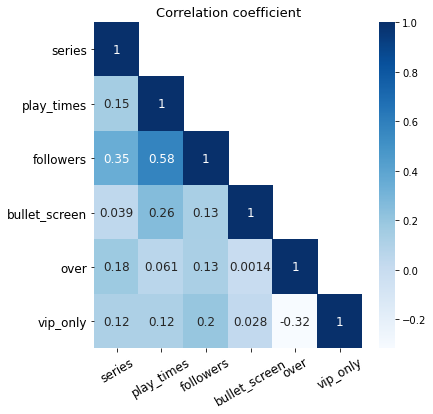

In [22]:
cor_mat = df_ols.corr()
dim = cor_mat.shape[0]
names = cor_mat.columns
for i in range(dim):
    for j in range(dim):
        # 仅显示一半相关系数矩阵
        if i < j:
            x = names[i]
            y = names[j]
            cor_mat.loc[x, y] = np.nan
plt.subplots(figsize=(dim, dim))
sns.heatmap(cor_mat, annot=True, vmax=1, square=False, cmap="Blues", cbar=True,
            annot_kws={"size": 12})
plt.yticks(size=12, rotation=0)
plt.xticks(size=12, rotation=30)
plt.title('Correlation coefficient',size=13)
plt.savefig('./figure/corr.jpg', dpi=200, bbox_inches='tight')

可以观察到，追番人数followers和播放次数之间play times高度线性相关

### 建立线性回归模型

#### 选取变量

In [23]:
# 观察相关系数，选取和响应变量相关系数最大的追番人数建立回归模型
y, X = dmatrices(
    formula_like = 'play_times ~  followers',
    data=df_ols,
    return_type='dataframe')

#### 建立模型并且求解模型

In [24]:
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             play_times   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     6545.
Date:                Thu, 23 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:51:57   Log-Likelihood:            -2.4226e+05
No. Observations:               13246   AIC:                         4.845e+05
Df Residuals:                   13244   BIC:                         4.845e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.797e+05   1.93e+05      1.967      0.049    1355.919    7.58e+05
followers     15.6317      0.193     80.901      0.000      15.253      16.010
==============================================================================
Omnibus:                    25139.256   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         86853401.343
Skew:                          14.372   Prob(JB):                         0.00
Kurtosis:                     398.652   Cond. No.                     1.05e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

回归模型的系数显著，R方也得到了一个较好的值

#### 模型拟合可视化

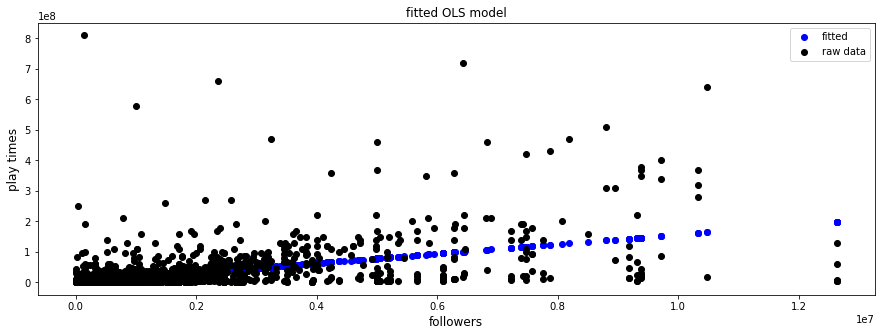

In [25]:
fig = plt.figure(figsize=(15, 5))
plt.scatter(df_ols.followers, model.fittedvalues, c='blue', label='fitted')
plt.scatter(df_ols.followers, df_ols.play_times, c='k', label='raw data')
plt.xlabel('followers', size=12)
plt.ylabel('play times', size=12)
plt.title('fitted OLS model')
plt.legend()
plt.savefig('./figure/fitted_OLS_model.jpg', dpi=200, bbox_inches='tight')

实际上回归效果不太好，但是一元线性回归局限于此，更加复杂的模型这里不做过多的探讨

## 番剧类型可视化

In [26]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
# 读取数据
df = pd.read_excel('./data/BLBLdata.xlsx')
df.shape

(14267, 16)

In [29]:
# 数据中的tag大多以字符存在，逗号隔开
df.head(1)['tags']

0    搞笑,泡面,日常,校园
Name: tags, dtype: object

### 大致了解类别的分布

#### 数据中所有涉及到的tag

In [30]:
# 这一行代码是对全部的tags进行合并、去重
tags_set = set(','.join(list(set(df.tags))[1:]).split(','))
print(len(tags_set), '\n', *tags_set)

93 
 惊悚 校园 少儿 旅行 真人秀 游戏改 神秘 职场 神魔 爱情 社会 罪案 原创 运动 家庭 年代 都市 谍战 宇宙 架空 古风 农村 萌宠 演唱会 魔法 军旅 美食 历史 喜剧 传记 战争 军事 旅游 恋爱 古装 动画 热血 文化 励志 萝莉 日常 悬疑 青春 医疗 特摄 奇幻 动态漫 恐怖 剧情 情感 犯罪 布袋戏 漫画改 动作 时泪 纪实 冒险 亲子 乙女 泡面 脱口秀 科幻 武侠 经典 少女 刑侦 萌系 偶像 催泪 人文 歌舞 战斗 机战 动物 玄幻 声控 灾难 探险 晚会 智斗 治愈 小说改 穿越 养成 访谈 音乐 推理 自然 搞笑 科技 选秀 社团 神话


#### 计数

In [31]:
def count_tag(dataframe):
    tags_l = []
    tag_count = {}
    # 初始化字典，这里没有使用collection的Counter是因为需要保留全部的key
    for tag in tags_set:
        tag_count[tag] = 0
    for i in dataframe.index:
        # 获取tag的字符串
        tag = dataframe.loc[i, 'tags']
        if pd.isna(tag):
            continue
        # 分割为列表，添加到tags_l后面
        tags_l += tag.split(',')
    # 计数
    for tag in tags_l:
        tag_count[tag] += 1
    return tag_count

#### 柱状图

In [32]:
tag_count = count_tag(df)

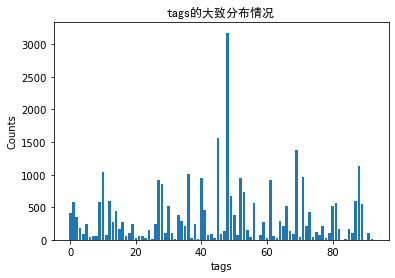

In [33]:
plt.bar(range(93),tag_count.values())
plt.title('tags的大致分布情况',fontfamily='SimHei')
plt.xlabel('tags')
plt.ylabel('Counts')
plt.savefig('./figure/tagsDistrubution.jpg', dpi=200, bbox_inches='tight')

B站的tag种类繁多，可以考虑将热门的tag拿出来分析，不那么热门的tag就列为其他

### 前十热门的tag

In [34]:
# Top 10 hot tags
sorted_key = sorted(tag_count, reverse=True,key=lambda x:tag_count.get(x))
sorted_values = [tag_count.get(key) for key in sorted_key]

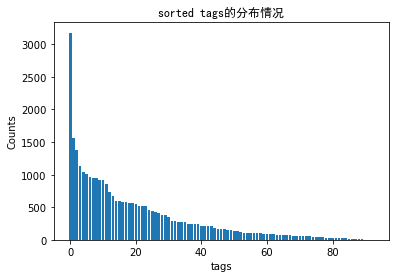

In [35]:
plt.bar(range(93),sorted_values)
plt.title('sorted tags的分布情况',fontfamily='SimHei')
plt.xlabel('tags')
plt.ylabel('Counts')
plt.savefig('./figure/sorted_tagsDistrubution.jpg', dpi=200, bbox_inches='tight')

tags的count分布比较连续，没有明显的断层，这种情况下不适宜做饼图

#### 南丁格尔玫瑰图

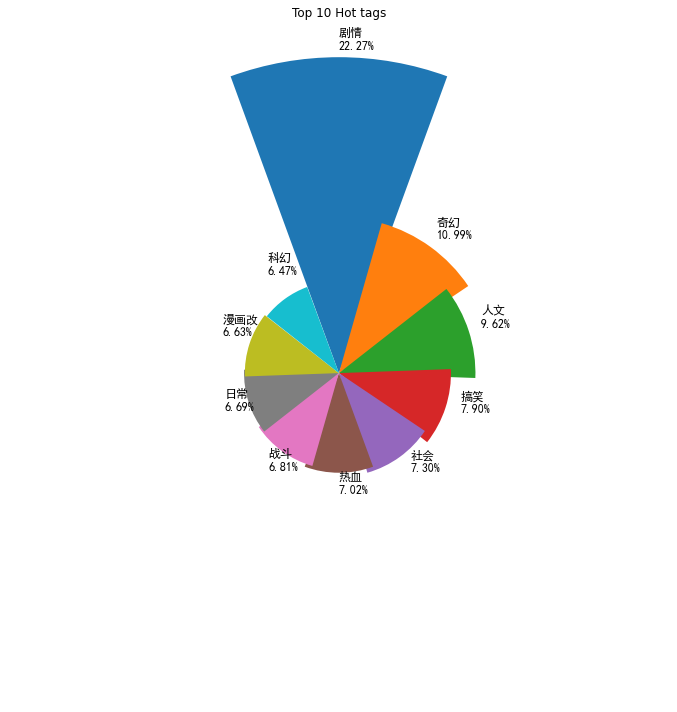

In [36]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, projection='polar')
# 顺时针
ax.set_theta_direction(-1)
# 从N开始（极坐标N表示南极
ax.set_theta_zero_location('N')
n = 10
# 注意这里角度的最大值设置为2*pi*(1 - 1/n)，可以恰好填满极坐标
angle = np.linspace(0, 2 * np.pi * (1 - 1 / n), n)

for i, theta in enumerate(angle):
    ax.bar(theta,
           sorted_values[:10][i],
           width=.55 if i == 9 else .7,
           label=sorted_key[i])
    ax.text(theta,
            sorted_values[:10][i] + theta * 40 + 80,
            f'{sorted_key[:10][i]}\n{sorted_values[:10][i]/len(df):.2%}',
            rotation=0,
            size=12,
           fontfamily='SimHei')
plt.axis('off')
plt.title('Top 10 Hot tags')
plt.tight_layout()
plt.savefig('./figure/top10tags.jpg', dpi=200, bbox_inches='tight')

图像是以plt的极坐标系为基础的，所以外围有空隙，可以考虑进行裁剪

#### 对图像进行裁剪

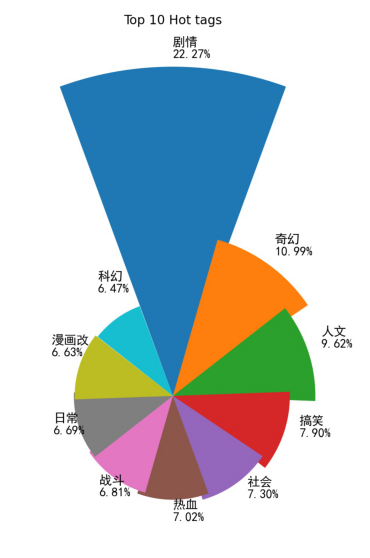

In [37]:
fig = plt.figure(figsize=(10, 10))
img = plt.imread("./figure/top10tags.jpg")
img = img[:1450,500:1450,:]
plt.imshow(img)
plt.axis('off')
plt.savefig('./figure/top10tags_cut.jpg', dpi=200, bbox_inches='tight')

通过南丁格尔玫瑰图可以很直观的看到B站最热门的几个tag，其中带有剧情tag的番剧最多

### tag丰富度变化

In [38]:
# df中加入年份这一列
df['year'] = [date.year for date in df.broadcast_date]

In [39]:
# 按照年份分组
df_group_by_year = df.groupby(by='year')

In [40]:
# 分组后每个组对tag计数
count_tag_by_year = {}
for year in df_group_by_year.groups:
    count_tag_by_year[year] = count_tag(df_group_by_year.get_group(year))

#### 番剧数量折线图

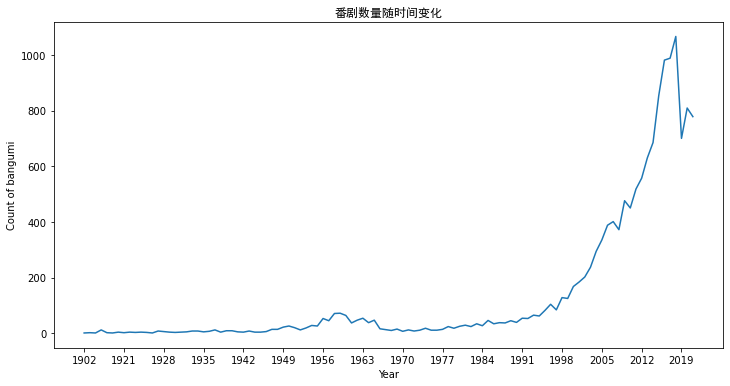

In [41]:
bangumi_count = []
for year in df_group_by_year.groups.keys():
    bangumi_count.append(df_group_by_year.get_group(year).shape[0])

firgure = plt.figure(figsize=(12, 6))
plt.plot(np.arange(108),bangumi_count)
plt.title('番剧数量随时间变化',fontfamily='SimHei')
plt.xlabel('Year')
plt.ylabel('Count of bangumi')
plt.xticks(np.arange(108)[::7],
           list(df_group_by_year.groups.keys())[::7],
           rotation=0)
plt.savefig('./figure/CountOfBangumi.jpg', dpi=200, bbox_inches='tight')

#### stackplot

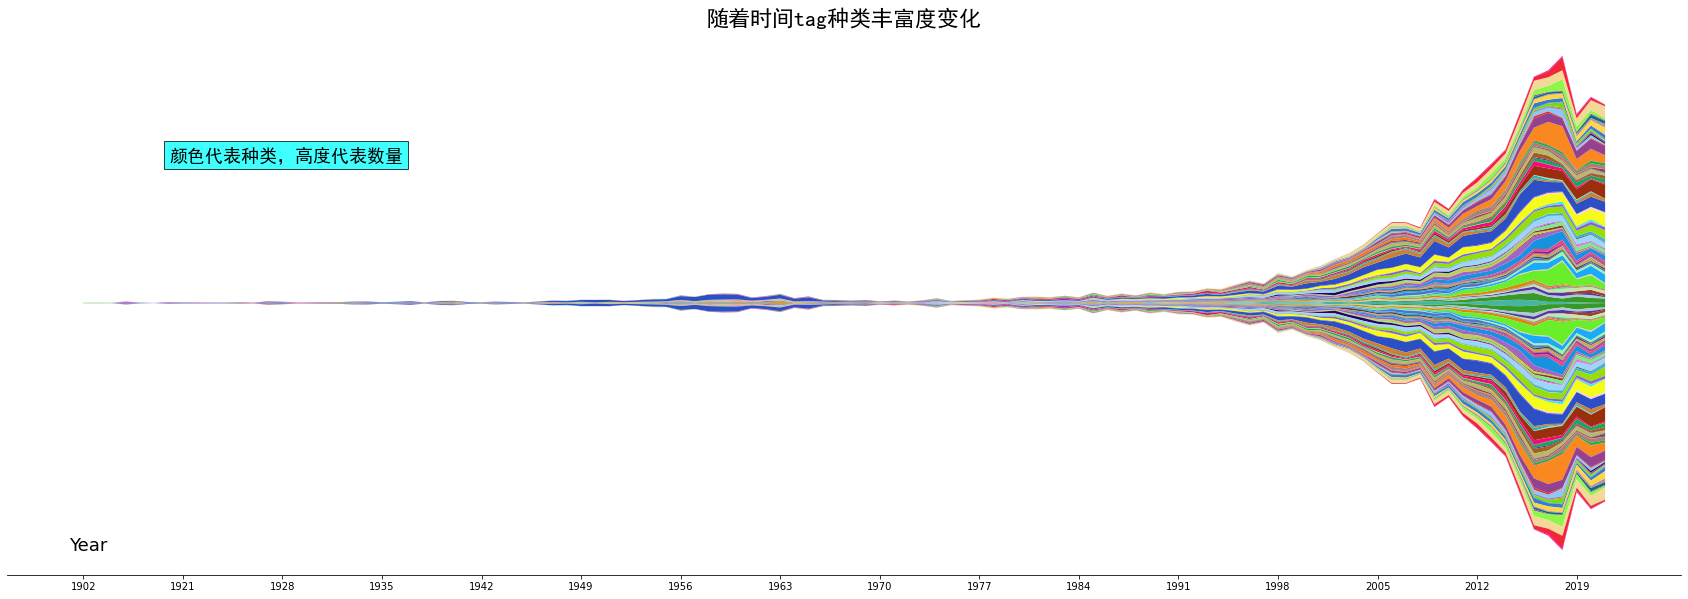

In [60]:
firgure = plt.figure(figsize=(30, 10))
ax = plt.subplot(111)
colors = np.random.random((93, 3))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# 对称作图
plt.stackplot(
    np.arange(108),
    np.array([
        list(count_tag_by_year[key].values()) for key in count_tag_by_year
    ]).T,
    colors=colors,
)
plt.stackplot(
    np.arange(108),
    -np.array(
        [list(count_tag_by_year[key].values())
         for key in count_tag_by_year]).T,
    colors=colors,
)
# 坐标轴
plt.xticks(np.arange(108)[::7],
           list(df_group_by_year.groups.keys())[::7],
           rotation=0)
plt.yticks([])
plt.title('随着时间tag种类丰富度变化', fontfamily='SimHei', size=22)
plt.text(-1, -2e3 - 450, 'Year', size=18)
plt.figtext(x=.2,
            y=.7,
            s='颜色代表种类，高度代表数量',
            fontsize=18,
            bbox={
                "facecolor": "cyan",
                "alpha": 0.75,
                "pad": 5
            },
            fontfamily='SimHei')
plt.savefig('./figure/tagsByYear.jpg', dpi=200, bbox_inches='tight')

> 注意这里的tag count会大于bangumi count，因为一个番剧会有多个tag，所以tag累计形成的折线略高于bangumi的折线

从stackplot可以清晰的看出，随着时间的推移，B站番剧的tag越发丰富，一方面是因为番剧数量确实增多了，另一方面是因为B站对番剧的tag进行了更加细化的分类